### Note: We need preprocessed texts (tokinized and numericalized) in this notebook

> Notebook based on:
> 1. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12_text.ipynb
> 2. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12a_awd_lstm.ipynb
> 3. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12b_lm_pretrain.ipynb
> 4. https://github.com/fastai/course-v3/blob/master/nbs/dl2/12c_ulmfit.ipynb
> 
> Video:
> - https://youtu.be/vnOpEwmtFJ8?t=4687 from 1:18:00 to 2:08:00 (50 mins)

# Constants

In [1]:
BPTT_LEN   = 70 # Lengh of the minisequences in the big stream (used In Dataset)
BATCH_SIZE = 64 # (used In DataLoader)
UNK_TOKEN  = 0  # Number for xxunk token (used in numericalization)
PAD_TOKEN  = 1  # Number for xxPad token (used in the nn.Embedding layer of the Model)
VOCAB_LEN  = None # This will be updated when we read the vocab.pkl file (used in the nn.Embedding layer)

# Imports

In [2]:
import numpy as np
import pathlib
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Sampler, DataLoader

import fastai
print("Pytorch:", torch.__version__)
print("Fast.ai:", fastai.__version__)

Pytorch: 1.8.1
Fast.ai: 2.3.1


# Data

In [3]:
!ls "../../Datasets/NLP/IMBd_prepro"

test  train  unsup  vocab.pkl


In [4]:
!ls "../../Datasets/NLP/IMBd_prepro/train"

neg  pos


# Read vocab

In [5]:
vocab_file = open("../../Datasets/NLP/IMBd_prepro/vocab.pkl",'rb')
imdb_vocab = pickle.load(vocab_file)

In [6]:
VOCAB_LEN = len(imdb_vocab)
VOCAB_LEN

65539

In [9]:
def numericalize(word):
    try:    return imdb_vocab.index(word)
    except: return UNK_TOKEN
    
def denumericalize(num):
    return imdb_vocab[num]

def numericalize_list(words):
    return [numericalize(word) for word in words]

def denumericalize_list(nums):
    return [denumericalize(num) for num in nums]

In [12]:
numericalize_list( ["hello", "world", "this_is_unknown_token"] )

[5255, 195, 0]

In [13]:
denumericalize_list( range(10) )

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 '.']

# Utils

In [9]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

def parallel_map(func, array):
    
    cpu_cores = multiprocessing.cpu_count()
    array_len = len(array)
    chunksize = array_len // 100
    
    if cpu_cores<2:
        return list(tqdm(map(func, arr), total=array_len))
    else:
        with ProcessPoolExecutor(max_workers=cpu_cores) as ex:
            return list(tqdm(ex.map(func, array, chunksize=chunksize), total=array_len))

---
# <center> Dataset & Dataloader for Langauge Model
- X: Text
- Y: Same text but shifted by 1 token

At every epoch:

1. **Shuffle** (sort randomly) our collection of texts.
2. **Concatenate** the individual texts together into a big stream. 
3. **Cut** this stream into a certain number of batches (which is our batch size).
   - For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens.
   
So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

# Dataset

In [10]:
class LM_Dataset(Dataset):
    
    def __init__(self, prepro_texts_dir, bptt=70, shuffle=False):
        
        # Read tokenized and numeralized text files (numpy format)
        np_filepaths = list( pathlib.Path(prepro_texts_dir).glob('**/*.npy') ) 
        
        # Open numpy arrays in parallel
        #self.texts_np = list(map(func=np.load, np_filepaths))  # Non parallel version   
        self.texts_np = parallel_map(func=np.load, array=np_filepaths)

        self.bptt    = bptt
        self.shuffle = shuffle
        self.total_tokens = sum([len(t) for t in self.texts_np])
        
        self.concat_texts_into_stream()
        
    # this is necesseary at the begining of every epoch for train !!!!
    def concat_texts_into_stream(self):
        
        # 1. Reorder texts if we need to
        if self.shuffle:
            np.random.shuffle(self.texts_np)
            #self.texts_np = self.texts_np[np.random.permutation(len(self.texts_np))]
            
        # 2. Concat texts into a large stream
        self.stream = np.concatenate(self.texts_np)
        #self.stream = torch.cat([torch.Tensor(t) for t in self.texts_np])
                
    def __len__(self):
        return self.total_tokens // self.bptt
    
    def __getitem__(self, idx):
        x = self.stream[idx   : idx+self.bptt]
        y = self.stream[idx+1 : idx+self.bptt+1] # shifted by 1
        
        # convert from numpy.uint16 to torch.int64        
        x = torch.tensor(x.astype("int64"))
        y = torch.tensor(y.astype("int64"))
        
        return x,y

In [11]:
train_ds = LM_Dataset("../../Datasets/NLP/IMBd_prepro/train", bptt=BPTT_LEN, shuffle=True)
valid_ds = LM_Dataset("../../Datasets/NLP/IMBd_prepro/test",  bptt=BPTT_LEN, shuffle=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [12]:
train_ds[1]

(tensor([    7,    83,    97,   343,    34,   397,    21,    31,    21,   113,
            47,    37,    43,    10,    37,   127,    10,    30,   297,  2506,
           397,  1202,     9,    24,     7,    63,    32,   200,   182,    14,
           114,    12,    97,   201,    31,    45,   242,  1385,    17,    65,
           558,    10,   614,    11,  1040,     9,     7,    54,    15,    65,
           558,  2244,    47, 17823,   611,   141,  3083,  3887,  1263,    45,
            12,     7,  2403,  1060,     9,     7,    54,    38,  7015,    11]),
 tensor([   83,    97,   343,    34,   397,    21,    31,    21,   113,    47,
            37,    43,    10,    37,   127,    10,    30,   297,  2506,   397,
          1202,     9,    24,     7,    63,    32,   200,   182,    14,   114,
            12,    97,   201,    31,    45,   242,  1385,    17,    65,   558,
            10,   614,    11,  1040,     9,     7,    54,    15,    65,   558,
          2244,    47, 17823,   611,   141,  3083,

In [13]:
train_ds[0][0].shape

torch.Size([70])

In [14]:
" ".join(denumericalize(train_ds[0][0])), " ".join(denumericalize(train_ds[0][1]))

('xxbos xxmaj really bad shot on video " film " made by not one , not two , but three amateur video makers . \n\n xxmaj if you \'re going to make a bad horror film at least throw in some blood , gore and nudity . xxmaj there is some blood provided by latex cut off arm props bought at a xxmaj halloween store . xxmaj there are lesbians',
 'xxmaj really bad shot on video " film " made by not one , not two , but three amateur video makers . \n\n xxmaj if you \'re going to make a bad horror film at least throw in some blood , gore and nudity . xxmaj there is some blood provided by latex cut off arm props bought at a xxmaj halloween store . xxmaj there are lesbians and')

# Dataloader (with custom sampler for BPTT)

if we divide our big stream of **28 elements** with **batch_size of 5**:

|               |              |               |               |               |               |
|---------------|--------------|---------------|---------------|---------------|---------------|
| **1st batch** | stream_idx 0 | stream_idx 6  | stream_idx 12 | stream_idx 18 | stream_idx 23 |
| **2nd batch** | stream_idx 1 | stream_idx 7  | stream_idx 13 | stream_idx 19 | stream_idx 24 |
| **3rd batch** | stream_idx 2 | stream_idx 8  | stream_idx 14 | stream_idx 20 | stream_idx 25 |
| **4th batch** | stream_idx 3 | stream_idx 8  | stream_idx 15 | stream_idx 21 | stream_idx 26 |
| **5th batch** | stream_idx 4 | stream_idx 10 | stream_idx 16 | stream_idx 22 | stream_idx 27 |
| **6th batch** | stream_idx 5 | stream_idx 11 | stream_idx 17 |               |               |

https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/samplers/bptt_sampler.html
    
    

In [15]:
class BPTT_BatchSampler(Sampler):
    def __init__(self, n_elements, batch_size, drop_last):
        
        indexes = np.array_split(list(range(n_elements)), batch_size) # magic happens here
        
        n_batches = n_elements//batch_size
        self.batches_idxs = np.array([x[:n_batches] for x in indexes]).T.tolist()
        
        if not drop_last:
            last_batch_idxs = np.array([x[n_batches:] for x in indexes if x[n_batches:].size==1]).T.tolist()
            self.batches_idxs += last_batch_idxs
        
    def __iter__(self):
        return iter(self.batches_idxs)
    
    def __len__(self):
        return len(self.batches_idxs)

In [16]:
s = BPTT_BatchSampler(n_elements=28, batch_size=5, drop_last=False)
len(s), list(s)

(6,
 [[0, 6, 12, 18, 23],
  [1, 7, 13, 19, 24],
  [2, 8, 14, 20, 25],
  [3, 9, 15, 21, 26],
  [4, 10, 16, 22, 27],
  [5, 11, 17]])

In [17]:
s = BPTT_BatchSampler(n_elements=28, batch_size=5, drop_last=True)
len(s), list(s)

(5,
 [[0, 6, 12, 18, 23],
  [1, 7, 13, 19, 24],
  [2, 8, 14, 20, 25],
  [3, 9, 15, 21, 26],
  [4, 10, 16, 22, 27]])

### Dataloader

In [18]:
train_dl = DataLoader(train_ds, batch_sampler=BPTT_BatchSampler(n_elements=len(train_ds),
                                                                batch_size=BATCH_SIZE,
                                                                drop_last=True))

valid_dl = DataLoader(valid_ds, batch_sampler=BPTT_BatchSampler(n_elements=len(valid_ds),
                                                                batch_size=BATCH_SIZE,
                                                                drop_last=True))

batch_x, batch_y = next(iter(train_dl))
batch_x.shape, batch_y.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

# Model: Pretrained LSTM from wikitext103

In [19]:
from fastai.text.all import *

### Get model layer structure

In [20]:
model = get_language_model(arch=AWD_LSTM, vocab_sz=60000 )
model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

### Put wikipedia pretrained weights into the model

In [21]:
model_path = untar_data(URLs.WT103_FWD)
model_path

Path('/home/javi/.fastai/data/wt103-fwd')

In [22]:
wikipedia_vocab_filepath  = model_path / "itos_wt103.pkl"
wikipedia_weights_filepath = model_path / "lstm_fwd.pth"

In [23]:
with open_file(wikipedia_vocab_filepath, 'rb') as file:
    wikipedia_vocab = pickle.load(file)

In [24]:
wikipedia_weights = torch.load(wikipedia_weights_filepath, map_location = lambda storage,loc: storage)
wikipedia_weights = clean_raw_keys(wikipedia_weights)

In [25]:
model.load_state_dict(wikipedia_weights)

<All keys matched successfully>

### Put new words (of IMDb) in the embedding layer

In [26]:
wiki_only_vocab = len(set(wikipedia_vocab) - set(imdb_vocab))
imdb_only_vocab = len(set(imdb_vocab) - set(wikipedia_vocab))
in_common_vocab = len(set(imdb_vocab) & set(wikipedia_vocab))

print("wiki vocab:", len(wikipedia_vocab))
print("imdb vocab:", len(imdb_vocab))
print("---------------------")
print(f"wiki only vocab: {wiki_only_vocab}")
print(f"imdb only vocab: {imdb_only_vocab} ({round(imdb_only_vocab/len(imdb_vocab)*100,2)}% of imdb)")
print(f"in common vocab: {in_common_vocab} ({round(in_common_vocab/len(imdb_vocab)*100,2)}% of imdb)")

wiki vocab: 60000
imdb vocab: 65539
---------------------
wiki only vocab: 22951
imdb only vocab: 28490 (43.47% of imdb)
in common vocab: 37049 (56.53% of imdb)


In [27]:
old_emb_matrix = model[0].encoder.weight.data
print(old_emb_matrix.shape)
old_emb_matrix

torch.Size([60000, 400])


tensor([[-0.1276,  0.0161,  0.1617,  ..., -0.1396,  0.6899, -0.0399],
        [ 0.0272,  0.0011,  0.0401,  ...,  0.0161,  0.0666, -0.0014],
        [ 0.6069, -0.5239,  0.1544,  ..., -0.2551, -0.3308, -0.0702],
        ...,
        [ 0.0096,  0.0814,  0.0213,  ...,  0.0712,  0.0810, -0.0045],
        [ 0.0283, -0.0176,  0.0361,  ...,  0.0756,  0.1470, -0.0139],
        [ 0.1267, -0.0656,  0.0362,  ..., -0.0191,  0.0673,  0.0154]])

In [28]:
new_emb_matrix = torch.zeros( (len(imdb_vocab), old_emb_matrix.size(1)) )
old_emb_matrix_mean = old_emb_matrix.mean(0)

for i,word in tqdm(enumerate(imdb_vocab), total=len(imdb_vocab)):
    
    try:
        # If the word exits on the wikipedia vocab -> Use existing embedding
        old_emb_idx = wikipedia_vocab.index(word)
        new_emb_matrix[i] = old_emb_matrix[old_emb_idx]
    except:
        # If the word is new -> Use default embedding (the mean)
        new_emb_matrix[i] = old_emb_matrix_mean

  0%|          | 0/65539 [00:00<?, ?it/s]

In [29]:
print(new_emb_matrix.shape)
new_emb_matrix

torch.Size([65539, 400])


tensor([[-0.1276,  0.0161,  0.1617,  ..., -0.1396,  0.6899, -0.0399],
        [ 0.0272,  0.0011,  0.0401,  ...,  0.0161,  0.0666, -0.0014],
        [ 0.6069, -0.5239,  0.1544,  ..., -0.2551, -0.3308, -0.0702],
        ...,
        [-0.1464,  0.0314,  0.1414,  ..., -0.1256,  0.2263, -0.2686],
        [ 0.0253,  0.0026,  0.0423,  ...,  0.0128,  0.0848, -0.0018],
        [ 0.0253,  0.0026,  0.0423,  ...,  0.0128,  0.0848, -0.0018]])

In [30]:
model[0].encoder = nn.Embedding(num_embeddings = new_emb_matrix.shape[0],
                                embedding_dim  = new_emb_matrix.shape[1],
                                padding_idx    = 1,
                                _weight        = new_emb_matrix)

In [31]:
model[0].encoder_dp.emb = nn.Embedding(num_embeddings = new_emb_matrix.shape[0],
                                embedding_dim  = new_emb_matrix.shape[1],
                                padding_idx    = 1,
                                _weight        = new_emb_matrix)

model[0].encoder_dp.emb.weight = model[0].encoder.weight # Weight tiying !!

In [32]:
model[1].decoder = nn.Linear(in_features  = new_emb_matrix.shape[1],
                             out_features = new_emb_matrix.shape[0],
                             bias = True)

model[1].decoder.weight = model[0].encoder.weight # Weight tiying !!
model[1].decoder.bias.data.zero_();

In [33]:
model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65539, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65539, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65539, bias=True)
    (output_dp): RNNDropout()
  )
)

### Test model
We return three things:
1. The true output (probabilities for each word),
2. The activations of the encoder with dropouts. (to help with regularization)
3. The activations of the encoder without dropouts. to help with regularization

Becouse of this, we need to use the [RNNCallback](https://docs.fast.ai/callback.rnn.html#RNNCallback) to only keep the true output for loss computation

In [35]:
batch_p, hid1, hid1 = model(batch_x) # prediction and something else
batch_p.shape, hid1.shape, hid1.shape

(torch.Size([64, 70, 65539]),
 torch.Size([64, 70, 400]),
 torch.Size([64, 70, 400]))

# Loss: Flat CrossEntropy

Custom CrossEntropyLossFlat inspired by [Fast.ai CrossEntropyLossFlat()](https://docs.fast.ai/losses.html#CrossEntropyLossFlat)

In [36]:
print("Pred:  ", batch_p.shape)
print("Target:", batch_y.shape)

Pred:   torch.Size([64, 70, 65539])
Target: torch.Size([64, 70])


In [37]:
batch_p_flatten = batch_p.view(-1, batch_p.shape[-1])
batch_y_flatten = batch_y.view(-1)

print("Pred:  ", batch_p_flatten.shape)
print("Target:", batch_y_flatten.shape)

Pred:   torch.Size([4480, 65539])
Target: torch.Size([4480])


In [38]:
class CrossEntropyLossFlat(nn.Module):
    """Flatten version of nn.CrossEntropyLoss()"""
    def forward(self, pred, target):
        pred_flatten   = pred.view(-1, pred.shape[-1])
        target_flatten = target.view(-1)
        return F.cross_entropy(pred_flatten, target_flatten)

In [39]:
ce_loss = nn.CrossEntropyLoss()

ce_loss(batch_p_flatten, batch_y_flatten)

tensor(5.3656, grad_fn=<NllLossBackward>)

In [40]:
ce_flat_loss = CrossEntropyLossFlat()
ce_flat_loss(batch_p, batch_y)

tensor(5.3656, grad_fn=<NllLossBackward>)

# Train

In [43]:
# Using Fast.ai: 2.3.1
from fastai.learner           import Learner
from fastai.data.core         import DataLoaders
from fastai.metrics           import accuracy, Perplexity

from fastai.callback.all      import * # For lr_find() and fit_one_cycle()
from fastai.callback.core     import Callback
from fastai.callback.progress import ProgressCallback, ShowGraphCallback
from fastai.callback.training import GradientClip
from fastai.callback.rnn      import ModelResetter, RNNCallback, RNNRegularizer
from fastai.callback.tracker  import EarlyStoppingCallback

In [44]:
class ShowGraphEveryBatchCallback(Callback):
    "Update a graph of training and validation loss"
        
    def after_batch(self):
        if self.iter%15 == 0:
            rec   = self.learn.recorder
            iters = range(len(rec.losses))
            x_bounds = (0, self.n_epoch * self.n_iter)
            y_bounds = (0, 10)
            self.progress.mbar.update_graph([(iters, rec.losses)], x_bounds, y_bounds)

In [47]:
learn = Learner(dls       = DataLoaders(train_dl, valid_dl),
                model     = model, 
                loss_func = CrossEntropyLossFlat(),
                metrics   = [accuracy, Perplexity],
                cbs       = [
                          #  TrainEvalCallback, # By default
                          #  Recorder,          # By default
                          #  ProgressCallback,  # By default
                             ModelResetter,
                             RNNCallback,
                             RNNRegularizer,
                             ShowGraphEveryBatchCallback,
                             GradientClip(max_norm=0.1),
                          #  TensorBoardCallback("/home/javi/Escritorio/tensorboard", trace_model=True)
                          #  partial(AvgStatsCallback,accuracy_flat),
                          #  Recorder,  #     Registers statistics (lr, loss and metrics) during training
                          #  partial(GradientClipping, clip=0.1),
                          #  partial(RNNTrainer, α=2., β=1.),
                          #  ParamScheduler({'lr': SchedLin(1e-3, 1e-2)})
                          #  EarlyStoppingCallback(patience=3)
                          #  SaveModelCallback()
                            ])
#learn.show_training_loop()

In [47]:
#learn.lr_find()
#fig = learn.recorder.plot(suggestion=True, return_fig=True);
#lr  = learn.recorder.min_grad_lr 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.992864,5.868248,0.197092,353.628693,09:18


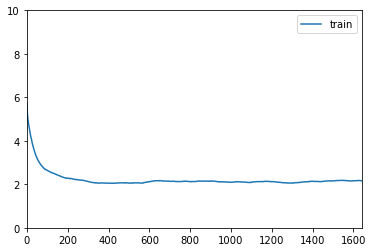

In [48]:
learn.fit(1, 1e-3) # learn.fit_one_cycle(1, 1e-2)

|experiment |epochs| lr        |train_loss | valid_loss |accuracy  | perplexity |time | notes                 |
|-----------|------|-----------|-----------|------------|----------|------------|-----|:---------------------:|
|     a     |  1   |           | 19.061800 | 45.006886  | 0.090237 |     -      |09:10|          -            |
|     b     |  1   |           | 5.943309  | 7.154285   | 0.090238 |1279.577148 |09:38| only predicts `xxmaj` |
|     c     |  1   |Const 1e-3 | 1.992864  | 5.868248   | 0.197092 | 353.628693 |09:18|                       |

Objetive (in 10 epochs) [video](https://youtu.be/vnOpEwmtFJ8?t=7549): train_loss=4.03 valid_loss=**4.06** valid_accuracy=**0.2867**

### Test model

In [55]:
batch_p,_,_= learn.model(batch_x.cuda())
#batch_p = batch_p.cpu()

In [59]:
accuracy(batch_p, batch_y.cuda()) # On some train batch

TensorBase(0.7792, device='cuda:0')

In [57]:
preds = batch_p.argmax(dim=-1)
preds

tensor([[   7,   54,  357,  ...,   38, 1551,   10],
        [  12,  429,   20,  ...,   12,   14,   40],
        [  13,   59,    8,  ...,   18,  217,   63],
        ...,
        [  10,    8, 2148,  ...,    8,   30,   10],
        [ 166,  435,   26,  ...,   73,   21,    8],
        [  10,   30, 2234,  ...,   10,  191,  268]], device='cuda:0')

In [58]:
preds.unique(return_counts=True)

(tensor([    0,     2,     3,  ..., 56009, 56717, 65100], device='cuda:0'),
 tensor([17, 12, 12,  ...,  1,  1,  1], device='cuda:0'))

# Play with model

### Save model

In [ ]:
#torch.save(learn.model.state_dict(), './language_model.pth')